In [27]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ECOS      # the solver we use in this hw 
# import Hypatia # other solvers you can try
# import COSMO   # other solvers you can try 
using ProgressMeter
include(joinpath(@__DIR__,"utils/rendezvous.jl"))

  Activating environment at `c:\Users\chenh\OneDrive\文档\最优控制\HW2_S24-main\Project.toml`


thruster_model (generic function with 1 method)

## Notes: 

1. Some of the cells below will have multiple outputs (plots and animations), it can be easier to see everything if you do `Cell -> All Output -> Toggle Scrolling`, so that it simply expands the output area to match the size of the outputs.
2. Things in space move very slowly (by design), because of this, you may want to speed up the animations when you're viewing them. You can do this in MeshCat by doing `Open Controls -> Animations -> Time Scale`, to modify the time scale. You can also play/pause/scrub from this menu as well. 
3. You can move around your view in MeshCat by `clicking + dragging`, and you can pan with `right click + dragging`, and zoom with the scroll wheel on your mouse (or trackpad specific alternatives). 

In [20]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

vec_from_mat (generic function with 1 method)

## Is LQR the answer for everything?

Unfortunately, no. LQR is great for problems with true quadratic costs and linear dynamics, but this is a very small subset of convex trajectory optimization problems. While a quadratic cost is common in control, there are other available convex cost functions that may better motivate the desired behavior of the system. These costs can be things like an L1 norm on the control inputs ($\|u\|_1$), or an L2 goal error ($\|x - x_{goal}\|_2$). Also, control problems often have constraints like path constraints, control bounds, or terminal constraints, that can't be handled with LQR. With the addition of these constraints, the trajectory optimization problem is stil convex and easy to solve, but we can no longer just get an optimal gain $K$ and apply a feedback policy in these situations. 

The solution to this is Model Predictive Control (MPC). In MPC, we are setting up and solving a convex trajectory optimization at every time step, optimizing over some horizon or window into the future, and executing the first control in the solution. To see how this works, we are going to try this for a classic space control problem: the rendezvous. 

# Q3: Optimal Rendezvous and Docking (55 pts)

In this example, we are going to use convex optimization to control the SpaceX Dragon 1 spacecraft as it docks with the International Space Station (ISS). The dynamics of the Dragon vehicle can be modeled with [Clohessy-Wiltshire equations](https://en.wikipedia.org/wiki/Clohessy%E2%80%93Wiltshire_equations), which is a linear dynamics model in continuous time. The state and control of this system are the following:

$$ \begin{align}
x &= [r_x, r_y, r_z, v_x, v_y, v_z]^T,\\
u &= [t_x, t_y, t_z]^T, \end{align}$$

where $r$ is a relative position of the Dragon spacecraft with respect to the ISS, $v$ is the relative velocity, and $t$ is the thrust on the spacecraft. The continuous time dynamics of the vehicle are the following:

$$ \begin{align}
\dot{x} &= \begin{bmatrix}0  &   0 & 0  &  1 &  0 &  0 \\  
         0 &    0 & 0  &  0 &  1 &  0 \\ 
         0 &    0 & 0 &   0 &  0 &  1\\
         3n^2 &0 & 0  &  0 &  2n &0 \\
         0  &   0 & 0  & -2n &0  & 0\\
         0  &   0 &-n^2 & 0 &  0 &  0 \end{bmatrix} + \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} u,
\end{align}$$
where $n = \sqrt{\mu/a^3}$, with $\mu$ being the [standard gravitational parameter](https://en.wikipedia.org/wiki/Standard_gravitational_parameter), and $a$ being the semi-major axis of the orbit of the ISS. 

We are going to use three different techniques for solving this control problem, the first is LQR, the second is convex trajectory optimization, and the third is convex MPC where we will be able to account for unmodeled dynamics in our system (the "sim to real" gap). 

## Part A: Discretize the dynamics (5 pts)

Use the matrix exponential to convert the linear ODE into a linear discrete time model (hint: the matrix exponential is just `exp()` in Julia when called on a matrix.

In [21]:
function create_dynamics(dt::Real)::Tuple{Matrix,Matrix}
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k

    Ad = zeros(6,6)
    Bd = zeros(6,3)

    exp_matrix = exp([A B; zeros(3,9)]*dt)
    Ad = exp_matrix[1:6, 1:6]
    Bd = exp_matrix[1:6, 7:end]

    return Ad, Bd
end

create_dynamics (generic function with 1 method)

In [22]:
@testset "discrete dynamics" begin 
    A,B = create_dynamics(1.0)
    
    x = [1,3,-.3,.2,.4,-.5]
    u = [-.1,.5,.3]
    
    # test these matrices 
    @test isapprox(A*x + B*u, [1.195453, 3.424786, -0.78499972, 0.190925, 0.4495759, -0.4699993], atol = 1e-3)
    @test isapprox(det(A), 1, atol = 1e-8)
    @test isapprox(norm(B,Inf), 0.0999999803, atol = 1e-5)
    
end

Test Summary:     | Pass  Total
discrete dynamics |    3      3


Test.DefaultTestSet("discrete dynamics", Any[], 3, false, false)

## Part B: LQR (10 pts)
Now we will take a given reference trajectory `X_ref` and track it with finite-horizon LQR. Remember that finite-horizon LQR is solving this problem:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref, i})^TQ(x_i - x_{ref, i}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N- x_{ref, N})^TQ_f
(x_N- x_{ref, N})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
where our policy is $u_i = -K_i(x_i - x_{ref, i})$. Use your code from the previous problem with your `fhlqr` function to generate your gain matrices. 

One twist we will throw into this is control constraints `u_min` and `u_max`. You should use the function `clamp.(u, u_min, u_max)` to clamp the values of your `u` to be within this range. 

If implemented correctly, you should see the Dragon spacecraft dock with the ISS successfuly, but only after it crashes through the ISS a little bit. 

In [24]:
# solution 
function fhlqr(A::Matrix, # A matrix 
    B::Matrix, # B matrix 
    Q::Matrix, # cost weight 
    R::Matrix, # cost weight 
    Qf::Matrix,# term cost weight 
    N::Int64   # horizon size 
    )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 

# check sizes of everything 
nx,nu = size(B)
@assert size(A) == (nx, nx)
@assert size(Q) == (nx, nx)
@assert size(R) == (nu, nu)
@assert size(Qf) == (nx, nx)

# instantiate S and K 
P = [zeros(nx,nx) for i = 1:N]
K = [zeros(nu,nx) for i = 1:N-1]

# initialize S[N] with Qf 
P[N] = deepcopy(Qf)

# Ricatti 
for k = (N-1):(-1):1 
K[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
P[k] = Q + K[k]'*R*K[k] + (A - B*K[k])'P[k+1]*(A - B*K[k])
end

return P, K 
end

fhlqr (generic function with 1 method)

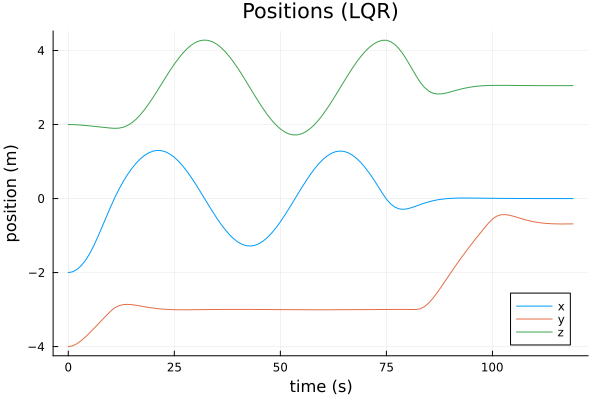

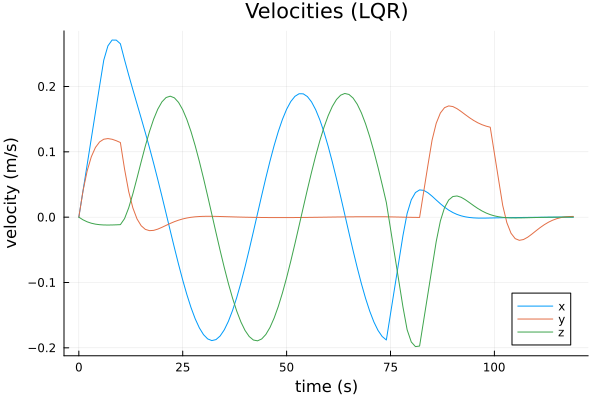

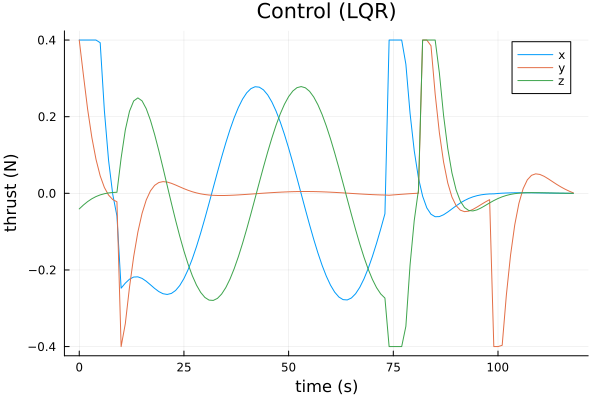

┌ Info: Listening on: 127.0.0.1:8731, thread id: 1
└ @ HTTP.Servers C:\Users\chenh\.julia\packages\HTTP\WctPa\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8731
└ @ MeshCat C:\Users\chenh\.julia\packages\MeshCat\ZB3jI\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8731, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8731), "127.0.0.1", "8731", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000013bc) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000001244eef0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0)), MeshCat.AnimationContext[]))

Test Summary:  | Pass  Total
LQR rendezvous |    6      6


Test.DefaultTestSet("LQR rendezvous", Any[], 6, false, false)

In [29]:
@testset "LQR rendezvous" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 120
    t_vec = 0:dt:((N-1)*dt)
    X_ref = desired_trajectory_long(x0,xg,200,dt)[1:N]
    
    # TODO: FHLQR 
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 10*Q
    # TODO get K's from fhlqr 
    P, K = fhlqr(A, B, Q, R, Qf, N)
    # simulation 
    X_sim = [zeros(nx) for i = 1:N]
    U_sim = [zeros(nu) for i = 1:N-1]
    X_sim[1] = x0 
    for i = 1:(N-1) 
        # TODO: put LQR control law here 
        # make sure to clamp 
        # U_sim[i] = zeros(3)
        U_sim[i] = clamp.(-K[i]*(X_sim[i]-X_ref[i]), u_min, u_max)
        # simulate 1 step 
        X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
    end

    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions (LQR)",
                 xlabel = "time (s)", ylabel = "position (m)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities (LQR)",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control (LQR)",
            xlabel = "time (s)", ylabel = "thrust (N)",
                 label = ["x" "y" "z"]))

    # feel free to toggle `show_reference`
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------

    
    # testing 
    xs=[x[1] for x in X_sim]
    ys=[x[2] for x in X_sim]
    zs=[x[3] for x in X_sim]
    @test norm(X_sim[end] - xg) < .01 # goal 
    @test (xg[2] + .1) < maximum(ys) < 0 # we should have hit the ISS 
    @test maximum(zs) >= 4 # check to see if you did the circle 
    @test minimum(zs) <= 2 # check to see if you did the circle 
    @test maximum(xs) >= 1 # check to see if you did the circle 
    @test maximum(norm.(U_sim,Inf)) <= 0.4 # control constraints satisfied 

end

## Part C: Convex Trajectory Optimization (15 pts)

Now we are going to assume that we have a perfect model (assume there is no sim to real gap), and that we have a perfect state estimate. With this, we are going to solve our control problem as a convex trajectory optimization problem. 

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref, i})^TQ(x_i - x_{ref, i}) + \frac{1}{2} u_i^TRu_i \bigg] \\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1  \\ 
 & u_{min} \leq u_i \leq u_{max} \quad \text{for } i = 1,2,\ldots,N-1 \\
 & x_i[2] \leq x_{goal} [2]\quad \text{for } i = 1,2,\ldots,N \\ 
 & x_N = x_{goal}
 \end{align}$$
 
 Where we have an LQR cost, an initial condition constraint ($x_1 = x_{\text{IC}}$), linear dynamics constraints ($x_{i+1} = A x_i + Bu_i$), bound constraints on the control ($\leq u_i \leq u_{max}$), an ISS collision constraint ($x_i[2] \leq x_{goal} [2]$), and a terminal constraint ($x_N = x_{goal}$).  This problem is convex and we will setup and solve this with `Convex.jl`. 

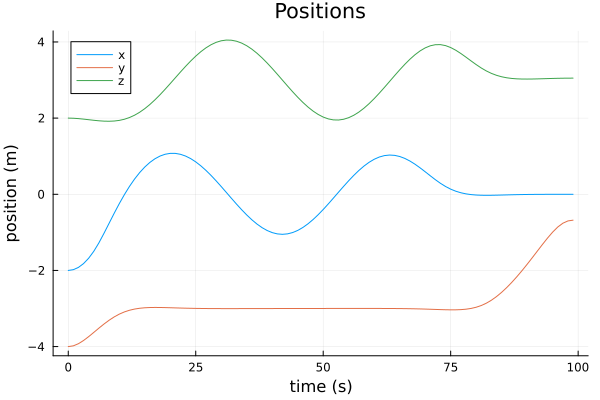

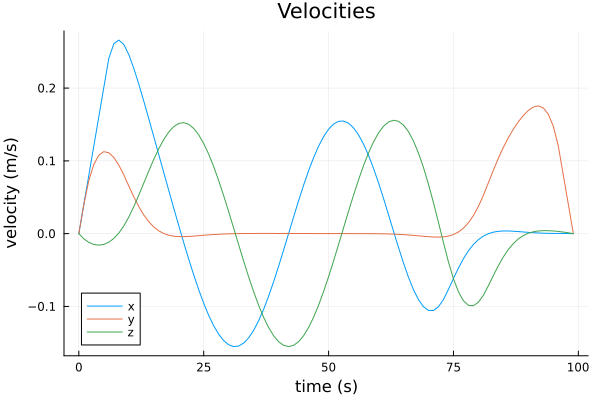

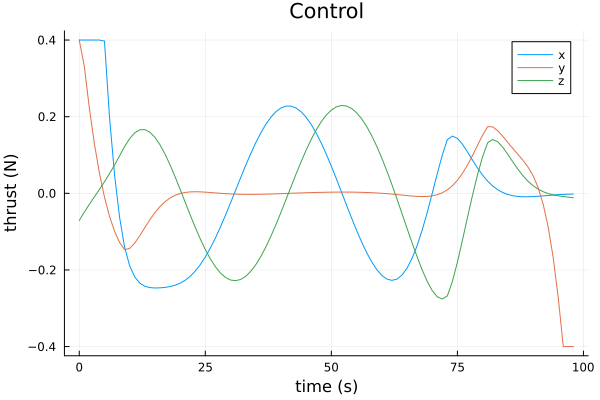

┌ Info: Listening on: 127.0.0.1:8734, thread id: 1
└ @ HTTP.Servers C:\Users\chenh\.julia\packages\HTTP\WctPa\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8734
└ @ MeshCat C:\Users\chenh\.julia\packages\MeshCat\ZB3jI\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8734, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8734), "127.0.0.1", "8734", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001ed8) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000010c020e0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0)), MeshCat.AnimationContext[]))

Test Summary:  | Pass  Total
convex trajopt |    7      7


Test.DefaultTestSet("convex trajopt", Any[], 7, false, false)

In [32]:
"""
Xcvx,Ucvx = convex_trajopt(A,B,X_ref,x0,xg,u_min,u_max,N)

setup and solve the above optimization problem, returning 
the solutions X and U, after first converting them to 
vectors of vectors with vec_from_mat(X.value)
"""
function convex_trajopt(A::Matrix, # discrete dynamics A 
                        B::Matrix, # discrete dynamics B 
                        X_ref::Vector{Vector{Float64}}, # reference trajectory 
                        x0::Vector, # initial condition 
                        xg::Vector, # goal state 
                        u_min::Vector, # lower bound on u 
                        u_max::Vector, # upper bound on u
                        N::Int64, # length of trajectory 
                        )::Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}} # return Xcvx,Ucvx
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    @assert size(A) == (nx, nx)
    @assert length(x0) == nx 
    @assert length(xg) == nx 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N)
    U = cvx.Variable(nu,N-1)

    # TODO: implement cost
    obj = 0 
    for i = 1:N-1
        obj += 0.5*cvx.quadform(X[:,i]-X_ref[i], Q)
        obj += 0.5*cvx.quadform(U[:,i], R)
    end

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    prob.constraints += (X[:,1]==x0)
    for i = 1:N-1
        prob.constraints += (X[:,i+1]==A*X[:,i]+B*U[:,i])
    end
    for i = 1:N-1
        prob.constraints += (U[:,i]<=u_max)
        prob.constraints += (U[:,i]>=u_min)
    end
    for i = 1:N
        prob.constraints += X[2,i]<=xg[2]
    end
    prob.constraints += X[:,end]==xg

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    X = X.value
    U = U.value
    
    Xcvx = vec_from_mat(X)
    Ucvx = vec_from_mat(U)
    
    return Xcvx, Ucvx
end
    
    
@testset "convex trajopt" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = desired_trajectory(x0,xg,N,dt) 
    
    # solve convex trajectory optimization problem 
    X_cvx, U_cvx = convex_trajopt(A,B,X_ref, x0,xg,u_min,u_max,N)
    
    X_sim = [zeros(nx) for i = 1:N]
    X_sim[1] = x0 
    for i = 1:N-1 
        X_sim[i+1] = A*X_sim[i] + B*U_cvx[i]
    end

    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_cvx)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                 xlabel = "time (s)", ylabel = "position (m)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                 label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------


    @test maximum(norm.( X_sim .- X_cvx, Inf)) < 1e-3 
    @test norm(X_sim[end] - xg) < 1e-3 # goal 
    xs=[x[1] for x in X_sim]
    ys=[x[2] for x in X_sim]
    zs=[x[3] for x in X_sim]
    @test maximum(ys) <= (xg[2] + 1e-3)
    @test maximum(zs) >= 4 # check to see if you did the circle 
    @test minimum(zs) <= 2 # check to see if you did the circle 
    @test maximum(xs) >= 1 # check to see if you did the circle 
    @test maximum(norm.(U_cvx,Inf)) <= 0.4 + 1e-3 # control constraints satisfied 

end

## Part D (5 pts): Short answer

1. List three reasons why an open loop policy wouldn't work well on a real system:
- **Model mismatch**
- **Disturbances**
- **Actuator errors/misalignments**


2. For convex trajectory optimization, give three examples of convex cost functions we can use:
- **L1 norm on control.**
- **Huber cost on state**
- **L2 norm on state error**

3. List three things that convex trajectory optimization can do that LQR cannot:
- **Actuator constraints**
- **State constraints**
- **Terminal constraints**
- **Non-quadratic costs**

4. Say we have the following convex trajectory optimization problem:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref, i})^TQ(x_i - x_{ref, i}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N- x_{ref, N})^TQ_f
(x_N- x_{ref, N})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 \\ 
 & x_{min} \leq x_i \leq x_{max} \quad \text{for } i = 1,2,\ldots,N\\ 
 & u_{min} \leq u_i \leq u_{max} \quad \text{for } i = 1,2,\ldots,N-1
 \end{align}
 $$
 If the optimal solution to this problem does not violate any either the state or control bounds (the $x_{min} \leq x_i \leq x_{max}$ and $u_{min} \leq u_i \leq u_{max}$ constraints), how will it differ from the finite-horizon LQR solution?
 
 **If the optimal solution to this problem does not activate the non-dynamics constraints, it will be the same as the LQR solution. These constraints are "inactive", which is the same as ignoring them. If we ignore them, we have our LQR problem.**

## Part E: Convex MPC (20 pts)

In part C, we solved for the optimal rendezvous trajectory using convex optimization, and verified it by simulating it in an open loop fashion (no feedback). This was made possible because we assumed that our linear dynamics were exact, and that we had a perfect estimate of our state. In reality, there are many issues that would prevent this open loop policy from being successful.

Together, these factors result in a "sim to real" gap between our simulated model, and the real model. Because there will always be a sim to real gap, we can't just execute open loop policies and expect them to be successful. What we can do, however, is use Model Predictive Control (MPC) that combines some of the ideas of feedback control with convex trajectory optimization. 

A convex MPC controller will set up and solve a convex optimization problem at each time step that incorporates the current state estimate as an initial condition. For a trajectory tracking problem like this rendezvous, we want to track $x_{ref}$, but instead of optimizing over the whole trajectory, we will only consider a sliding window of size $N_{mpc}$ (also called a horizon). If $N_{mpc} = 20$, this means our convex MPC controller is reasoning about the next 20 steps in the trajectory. This optimization problem at every timestep will start by taking the relevant reference trajectory at the current window from the current step $i$, to the end of the window $i + N_{mpc} - 1$. This slice of the reference trajectory that applies to the current MPC window will be called $\tilde{x}_{ref} = x_{ref}[i,(i + N_{mpc} - 1)]$.



$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - \tilde{x}_{ref, i})^TQ({x}_i - \tilde{x}_{ref, i}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N- \tilde{x}_{ref, N})^TQ
({x}_N- \tilde{x}_{ref, N})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1  \\ 
 & u_{min} \leq u_i \leq u_{max} \quad \text{for } i = 1,2,\ldots,N-1 \\
 & x_i[2] \leq x_{goal} [2]\quad \text{for } i = 1,2,\ldots,N 
 \end{align}$$
 
where $N$ in this case is $N_{mpc}$. This allows for the MPC controller to "think" about the future states in a way that the LQR controller cannot. By updating the reference trajectory window ($\tilde{x}_{ref}$) at each step and updating the initial condition ($x_{IC}$), the MPC controller is able to "react" and compensate for the sim to real gap. 

You will now implement a function `convex_mpc` where you setup and solve this optimization problem at every timestep, and simply return $u_1$ from the solution. 

simulating 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Listening on: 127.0.0.1:8740, thread id: 1
└ @ HTTP.Servers C:\Users\chenh\.julia\packages\HTTP\WctPa\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8740
└ @ MeshCat C:\Users\chenh\.julia\packages\MeshCat\ZB3jI\src\visualizer.jl:43


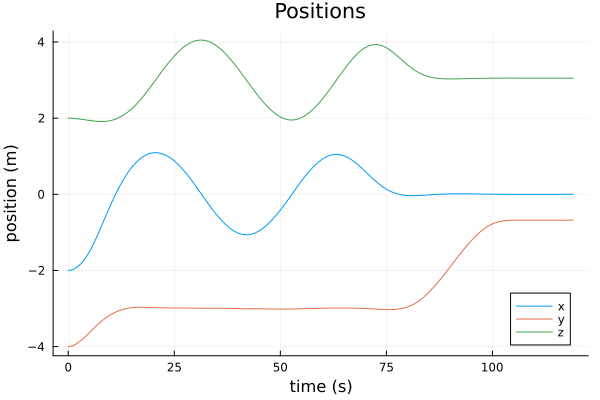

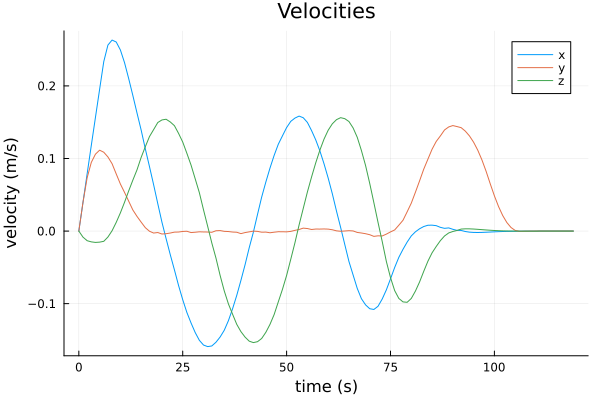

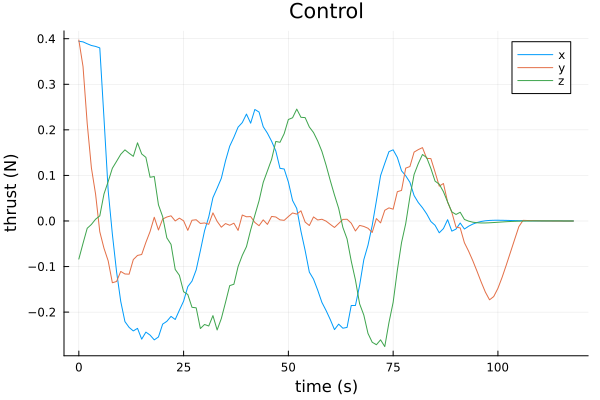

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8740, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8740), "127.0.0.1", "8740", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000014b4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000082956590, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0)), MeshCat.AnimationContext[]))

Test Summary: | Pass  Total
convex mpc    |    6      6


Test.DefaultTestSet("convex mpc", Any[], 6, false, false)

In [42]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    xg::Vector, # goal state 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # TODO: implement cost function
    obj = 0
    for k = 1:N_mpc-1
        obj += 0.5*cvx.quadform(X[:,k]-X_ref_window[k], Q)
        obj += 0.5*cvx.quadform(U[:,k], R)
    end
    obj += 0.5*cvx.quadform(X[:,N_mpc]-X_ref_window[N_mpc], Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    prob.constraints += X[:,1]==xic
    for k = 1:N_mpc-1
        prob.constraints += X[:,k+1]==A*X[:,k]+B*U[:,k]
        prob.constraints += U[:,k]<=u_max
        prob.constraints += U[:,k]>=u_min
        prob.constraints += X[2,k]<=xg[2]
    end
    prob.constraints += X[2,N_mpc]<=xg[2]

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end
        
@testset "convex mpc" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = [desired_trajectory(x0,xg,N,dt)...,[xg for i = 1:N]...] 
    # MPC window size 
    N_mpc = 20 
    
    # sim size and setup 
    N_sim = N + 20 
    t_vec = 0:dt:((N_sim-1)*dt)
    X_sim = [zeros(nx) for i = 1:N_sim]
    X_sim[1] = x0 
    U_sim = [zeros(nu) for i = 1:N_sim-1]
    
    # simulate 
    @showprogress "simulating" for i = 1:N_sim-1 
        
        # get state estimate
        xi_estimate = state_estimate(X_sim[i], xg)
        
        # TODO: given a window of N_mpc timesteps, get current reference trajectory
        X_ref_tilde = X_ref[i:i+N_mpc-1]
        
        # TODO: call convex mpc controller with state estimate 
        u_mpc = convex_mpc(A, B, X_ref_tilde, xi_estimate, xg, u_min, u_max, N_mpc)
        
        # commanded control goes into thruster model where it gets modified 
        U_sim[i] = thruster_model(X_sim[i], xg, u_mpc)
        
        # simulate one step 
        X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
    end
    
    

    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                 xlabel = "time (s)", ylabel = "position (m)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                 label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------

    # tests 
    @test norm(X_sim[end] - xg) < 1e-3 # goal 
    xs=[x[1] for x in X_sim]
    ys=[x[2] for x in X_sim]
    zs=[x[3] for x in X_sim]
    @test maximum(ys) <= (xg[2] + 1e-3)
    @test maximum(zs) >= 4 # check to see if you did the circle 
    @test minimum(zs) <= 2 # check to see if you did the circle 
    @test maximum(xs) >= 1 # check to see if you did the circle 
    @test maximum(norm.(U_sim,Inf)) <= 0.4 + 1e-3 # control constraints satisfied 

end